# L10 - PyTorch II

https://bit.ly/torch-intro2 / https://colab.research.google.com/drive/1FfV-mgj6P_Z0ulmigUnHr3KB57scEGmS?usp=sharing

Today, we will take a hands-on approach to understanding the basics of Multilayer Perceptrons (MLPs) using PyTorch.

We will cover data handling through to model evaluation, focusing on a 1D dataset: MNIST1D.
(This dataset simplifies the classic MNIST problem into a format where each sample has 100 features, representing a condensed version of the more traditional 2D images.)

If we have time we will also look at the double descent phenomena.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy as np

Let's get the dataset:

In [2]:
import requests, pickle

url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
r = requests.get(url, allow_redirects=True)
open('./mnist1d_data.pkl', 'wb').write(r.content)

with open('./mnist1d_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
data.keys()

dict_keys(['x', 'x_test', 'y', 'y_test', 't', 'templates'])

In [3]:
data['x'].shape, data['y'].shape

((4000, 40), (4000,))

## Data Preparation

PyTorch parametrizes useful data loading objects such as `DataLoader` for managing data. This allows us to easily batch our data, shuffle it for training, and utilize multiprocessing to load data in parallel (concurrent with GPU kernel execution!).

We will also use `TensorDataset` which is an easy way to mini-batch any ndarray-like dataset.


In [4]:
X = torch.tensor(data['x'], dtype=torch.float32)
y = torch.tensor(data['y'], dtype=torch.long)

# We wrap our dataset in a TensorDataset, which provides a convenient way of pairing feature and label tensors.
dataset = TensorDataset(X, y)

# Next, split our dataset into training and validation sets to enable model evaluation during training.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Now, let's create DataLoader instances for both sets.
# DataLoaders provide an iterable over our dataset and support automatic batching, sampling, shuffling, and multiprocess data loading.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [5]:
train_loader.dataset

## Building the Model
With our data prepared, we now focus on constructing our model.

In PyTorch, any custom model is defined by subclassing the `nn.Module` class.

For our purposes, we'll design a simple Multilayer Perceptron (MLP) with a few hidden layers.


In [6]:
class SimpleMLP(nn.Module):
    def __init__(self, hidden=128, act=nn.ReLU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X.shape[-1], hidden),
            act(),
            nn.Linear(hidden, hidden),
            act(),
            nn.Linear(hidden, hidden),
            act(),
            nn.Linear(hidden, 10)  # 10 output classes
        )

        
    def forward(self, x):
        return self.net(x)  # logits


model = SimpleMLP(hidden=32)

Here is a really nice part about PyTorch:

*any* PyTorch nn.Module stored in a model (i.e., `self.<var> = ...`) is tracked as part of the object's state!

## Training the Model

Training a neural network involves forward propagation of input data through the network to make predictions, calculating the loss, and performing backpropagation to update the model's weights.

In PyTorch, this process is facilitated by the use of a loss function and an optimizer.

In [7]:
loss_fn = nn.CrossEntropyLoss()  # Loss function suitable for classification tasks
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Optimizer suitable for classification tasks
# optimizer = optim.Adam(model.parameters(), lr=0.001) # Uncomment to use Adam instead

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
epochs = 1000  # Number of epochs to train for
train_losses, val_losses = [], []  # Lists to keep track of progress

for epoch in range(epochs):
    model.train()  # Set model to training mode
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Clear previous gradients
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)  # Forward pass
        loss = loss_fn(y_pred, y_batch)  # Calculate loss
        loss.backward()  # Backward pass to calculate gradients
        optimizer.step()  # Update weights
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # No gradient tracking needed for validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            val_loss += loss_fn(y_pred, y_batch).item()
    val_losses.append(val_loss / len(val_loader))
    
    # Print progress
    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

Epoch 1: Train Loss = 2.3074, Val Loss = 2.3105
Epoch 2: Train Loss = 2.3046, Val Loss = 2.3080
Epoch 3: Train Loss = 2.3018, Val Loss = 2.3054
Epoch 4: Train Loss = 2.2993, Val Loss = 2.3029
Epoch 5: Train Loss = 2.2967, Val Loss = 2.3005
Epoch 6: Train Loss = 2.2940, Val Loss = 2.2978
Epoch 7: Train Loss = 2.2912, Val Loss = 2.2950
Epoch 8: Train Loss = 2.2882, Val Loss = 2.2919
Epoch 9: Train Loss = 2.2847, Val Loss = 2.2884
Epoch 10: Train Loss = 2.2808, Val Loss = 2.2843
Epoch 11: Train Loss = 2.2763, Val Loss = 2.2793
Epoch 12: Train Loss = 2.2709, Val Loss = 2.2734
Epoch 13: Train Loss = 2.2644, Val Loss = 2.2660
Epoch 14: Train Loss = 2.2564, Val Loss = 2.2572
Epoch 15: Train Loss = 2.2464, Val Loss = 2.2456
Epoch 16: Train Loss = 2.2337, Val Loss = 2.2313
Epoch 17: Train Loss = 2.2177, Val Loss = 2.2132
Epoch 18: Train Loss = 2.1978, Val Loss = 2.1898
Epoch 19: Train Loss = 2.1728, Val Loss = 2.1617
Epoch 20: Train Loss = 2.1431, Val Loss = 2.1290
Epoch 21: Train Loss = 2.1097

## Visualizing Training Progress
It's often helpful to visualize the training and validation loss over time. This can give us insights into how well the model is learning and whether it's overfitting or underfitting.

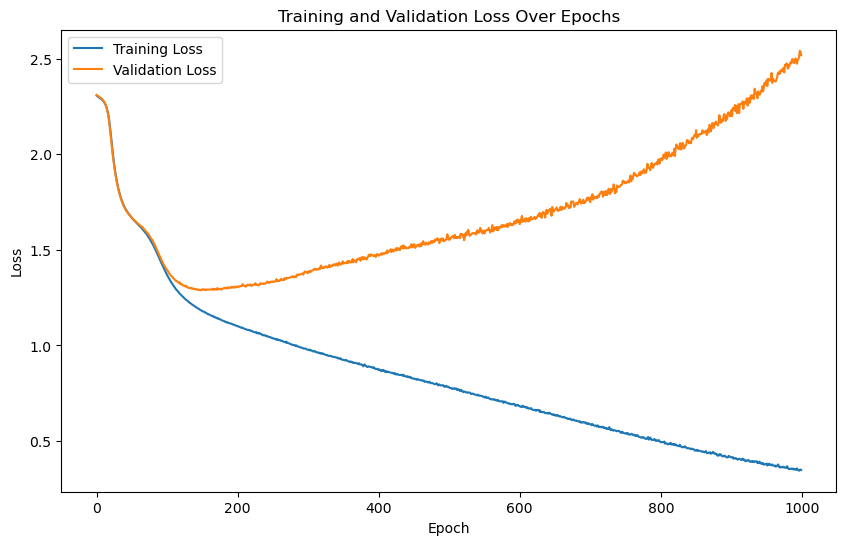

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Evaluating the Model

After training, we can our model's performance on unseen data.

This typically involves using a separate test set (i.e., not validation!).
(This is usually the very last step in the process of training a model.)
However, here we will use the validation set to evaluate the model.

In [10]:
model.eval()  # Set model to evaluation mode
correct, total = 0, 0
with torch.no_grad():  # No gradients required for evaluation
    for X_batch, y_batch in val_loader:
        y_pred = model(X_batch)
        predicted = torch.argmax(y_pred, axis=1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy*100:.2f}%")

Validation Accuracy: 53.12%


## Conclusion
In this lecture, we've covered the critical steps involved in building, training, and evaluating a neural network with PyTorch. Starting from data preparation, we moved through defining a simple MLP model, training it on our dataset, and finally evaluating its performance.

Continue experimenting with different architectures, optimizers, and learning rates to deepen your understanding of deep learning with PyTorch.

Next time:

- Modularity
- Training pipelines
- Best practices
- PyTorch Lightning, Weights & Biases

# (If we have time) Observing deep double descent

This notebook investigates double descent as described in section 8.4 of the ["Understanding Deep Learning"](https://udlbook.github.io/udlbook/) textbook.
Modified from original [notebook](https://github.com/greydanus/mnist1d).


In [11]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt


In [12]:
with open('./mnist1d_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
data.keys()

# Add 15% noise to training labels
for c_y in range(len(data['y'])):
    random_number = np.random.rand()
    if random_number < 0.15 :
        random_int = int(np.random.rand() * 10)
        data['y'][c_y] = random_int

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [13]:
# Manually initialize model:
def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_uniform_(layer_in.weight)
        layer_in.bias.data.fill_(0.0)
        # Choose to init biases to 0

def get_model(n_hidden):

    model = SimpleMLP(hidden=n_hidden)

    # Call the function you just defined
    model.apply(weights_init)

    # Return the model
    return model

In [14]:
def fit_model(model, data):

  # choose cross entropy loss function (equation 5.24)
  loss_function = torch.nn.CrossEntropyLoss()
  # construct SGD optimizer and initialize learning rate and momentum
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)


  # create 100 dummy data points and store in data loader class
  x_train = torch.tensor(data['x'].astype('float32'))
  y_train = torch.tensor(data['y'].transpose().astype('long'))
  x_test= torch.tensor(data['x_test'].astype('float32'))
  y_test = torch.tensor(data['y_test'].astype('long'))

  # load the data into a class that creates the batches
  data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

  # loop over the dataset n_epoch times
  n_epoch = 1000

  for epoch in range(n_epoch):
    # loop over batches
    for i, batch in enumerate(data_loader):
      # retrieve inputs and labels for this batch
      x_batch, y_batch = batch
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward pass -- calculate model output
      pred = model(x_batch)
      # compute the loss
      loss = loss_function(pred, y_batch)
      # backward pass
      loss.backward()
      # SGD update
      optimizer.step()

    # Run whole dataset to get statistics -- normally wouldn't do this
    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_test= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
    losses_train = loss_function(pred_train, y_train).item()
    losses_test= loss_function(pred_test, y_test).item()
    if epoch%100 ==0 :
      print(f'Epoch {epoch:5d}, train loss {losses_train:.6f}, train error {errors_train:3.2f},  test loss {losses_test:.6f}, test error {errors_test:3.2f}')

  return errors_train, errors_test

## The following code produces the double descent curve by training the model with different numbers of hidden units and plotting the test error.

In [15]:
# This code will take a while (~30 mins on GPU) to run!  Go and make a cup of coffee!

hidden_variables = np.array([2,4,6,8,10,14,18,22,26,30,35,40,45,50,55,60,70,80,90,100,120,140,160,180,200,250,300,400])
errors_train_all = np.zeros_like(hidden_variables)
errors_test_all = np.zeros_like(hidden_variables)

# For each hidden variable size
for c_hidden in range(len(hidden_variables)):
    print(f'Training model with {hidden_variables[c_hidden]:3d} hidden variables')
    # Get a model
    model = get_model(hidden_variables[c_hidden]) ;
    # Train the model
    errors_train, errors_test = fit_model(model, data)
    # Store the results
    errors_train_all[c_hidden] = errors_train
    errors_test_all[c_hidden]= errors_test

Training model with   2 hidden variables
Epoch     0, train loss 2.302297, train error 89.47,  test loss 2.302797, test error 91.10
Epoch   100, train loss 2.302106, train error 89.47,  test loss 2.303691, test error 91.10
Epoch   200, train loss 2.302108, train error 89.47,  test loss 2.303641, test error 91.10
Epoch   300, train loss 2.302105, train error 89.47,  test loss 2.303726, test error 91.10
Epoch   400, train loss 2.302105, train error 89.47,  test loss 2.303602, test error 91.10
Epoch   500, train loss 2.302108, train error 89.47,  test loss 2.303749, test error 91.10
Epoch   600, train loss 2.302110, train error 89.47,  test loss 2.303719, test error 91.10
Epoch   700, train loss 2.302103, train error 89.47,  test loss 2.303713, test error 91.10
Epoch   800, train loss 2.302111, train error 89.47,  test loss 2.303636, test error 91.10
Epoch   900, train loss 2.302104, train error 89.47,  test loss 2.303660, test error 91.10
Training model with   4 hidden variables
Epoch   

KeyboardInterrupt: 

In [ ]:
plt.figure(dpi=250, figsize=[4,2.5])
plt.plot(hidden_variables, errors_train_all,'r.-', label='train', alpha=0.33, linewidth=2.5)
plt.plot(hidden_variables, errors_test_all,'b.-', label='test', linewidth=2.5)
plt.ylim(-5,80);
plt.xlabel('Size of hidden layer'); plt.ylabel('Test error')
plt.legend(ncols=2)
plt.show()